In [1]:
# import the library
import googlemaps
import configparser
from geopy.geocoders import Nominatim
import pandas as pd

config = configparser.ConfigParser()
config.read('config.ini')

# Define the API Key.
API_KEY = config['GOOGLEMAPS_API']['API_KEY']
latitude = config['LOC']['LATITUDE']
longitude = config['LOC']['LONGITUDE']

# Initialize the geocoder
geolocator = Nominatim(user_agent="my_geocoder")

location = geolocator.geocode(f"{latitude} {longitude}")
latitude_dd = location.latitude
longitude_dd = location.longitude

print(f"Latitude in Decimal Degrees: {latitude_dd}")
print(f"Longitude in Decimal Degrees: {longitude_dd}")

# Define the Client
gmaps = googlemaps.Client(key = API_KEY)

Latitude in Decimal Degrees: 41.8932408
Longitude in Decimal Degrees: 12.482981487083691


In [37]:
# Do a simple nearby search where we specify the location
# in lat/lon format, along with a radius measured in meters
places_result  = gmaps.places_nearby(location=f'{latitude_dd},{longitude_dd}', radius = 500)
print(places_result)
print(len(places_result['results']))

{'html_attributions': [], 'next_page_token': 'ATJ83zg_gIDDE8ettAvhpJjKmDeiKXpj3sDLpiSUfb7-reN4cQ1CpH-hsUFx9QWcW7JsU3nlzU4Dm0xQ-C43q_H4-cjGHhtqgVpPBkiNQxrg6ZZ6Jv6LR2D_r7kAfuNChmMDBPbuzvf4aflFRfYX7beG0s1kViyBZ4lxNX5rSoY7JQ4_hRP62vLfiSijA2YJDrpIMRitOigNtlFg1kmrNDoLaFxT3ltN7I4IZYrMeiE8mP4ObriFTddORKNb9_eZAYjFmAuo-nT9NqAhvRAIvBoxxrRc8KLG1cXDsuKRKBQne0dzKq7lmovzA2djmrB4vvMRsCbDP4km4uNKFtrBU95x2Bad_RNM73yncTOkrnHKJNmRre9SbO0I0Ld3uVV17PckCU66eiT-RS2wnSH7d5gd96KNjWpwzuHy88TKPhc2nX2h', 'results': [{'geometry': {'location': {'lat': 41.9027835, 'lng': 12.4963655}, 'viewport': {'northeast': {'lat': 42.05054624539585, 'lng': 12.73028878823088}, 'southwest': {'lat': 41.76959604595655, 'lng': 12.34170704408109}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/geocode-71.png', 'icon_background_color': '#7B9EB0', 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/generic_pinlet', 'name': 'Rome', 'photos': [{'height': 1536, 'html_attributions': ['<a href="h

In [39]:
places_result1 = gmaps.places_nearby(location=f'{latitude_dd},{longitude_dd}',radius = 500, page_token=places_result['next_page_token'])
print(places_result1)
print(len(places_result1['results']))

{'html_attributions': [], 'next_page_token': 'ATJ83zhpZpOPA7bZbh6uFGefe59GZWWs5_5PJDfCcLyut2xYCaYnQCwBYxoyGIOvCpYx-KtRgIRaAzxtIXTueo8YodrEDwh-lVGboLWF1-FCqdL8W_A4FRxZaH4CzHwKDZh67OPymMYO7yc_8a3oZ8WPQIGVXAqfZrYciebQ-Qp97XvyX7LgEg_vkPPrmNseWVXoXSYqt2z-Ah_ZvD_qA29lW_I2-dQTm6XYpK6S8OCDnfR8aUaeQ59HTXQv8BS0XkJM9E9HWrNtNTgvsy2mDFIjWOKb6yGDdwOp972wf1qy2LUeMnD66RkDxeSaWeX_gFTjWfaMusCgZmAPFz4SRZOMCKjENC_VRMeBdyG85wsmKpqiyndeup4ODHzoqJx6It4PFf8mb_ijxBibvfxFR_sABmf5RJsuy_GxH0QnoeSE34kND30dO6Z0984I2R2AIXPXo0L9x8gUzECFDhooMemgdLkhVoxeezAcCEjtTFSI8QdoOkWa9YWahYe317TLl0QVasCET7kJe1ze2Xq9KXkyp8JRFqT46pyvdbuOhHJDXHILrdcJKa-ChkNN-l6w3YJ7ZIsppSqCtUW7bKayaGPWdEZXNQO6FgXnPJRKC37CsgHuqKE3gyIVSDNlBoPmIXKcRA', 'results': [{'business_status': 'OPERATIONAL', 'geometry': {'location': {'lat': 41.89316549999999, 'lng': 12.4882846}, 'viewport': {'northeast': {'lat': 41.89462508029149, 'lng': 12.4895869302915}, 'southwest': {'lat': 41.89192711970849, 'lng': 12.4868889697085}}}, 'icon': 'https://maps.gstatic.com/mapfi

In [40]:
places_result2 = gmaps.places_nearby(location=f'{latitude_dd},{longitude_dd}',radius = 500, page_token=places_result1['next_page_token'])
print(places_result2)
print(len(places_result2['results']))

{'html_attributions': [], 'results': [{'business_status': 'OPERATIONAL', 'geometry': {'location': {'lat': 41.8904138, 'lng': 12.4803379}, 'viewport': {'northeast': {'lat': 41.8917981802915, 'lng': 12.4818464802915}, 'southwest': {'lat': 41.8891002197085, 'lng': 12.4791485197085}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/civic_building-71.png', 'icon_background_color': '#7B9EB0', 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/civic-bldg_pinlet', 'name': 'Uffici Informativi Polifunzionali', 'photos': [{'height': 1037, 'html_attributions': ['<a href="https://maps.google.com/maps/contrib/114111166124838939526">Σπύρος Ιωνάς</a>'], 'photo_reference': 'ATJ83zjuJHf-wTXL2rYdWg_nCXuRoVxqnoMf4TRd1D3OuNc5ctCjcoP4iVhz0CNZxFUSr6pHxzttb7e5lLuwWnt3Lzx3TJqTT3Kwq9OPOJkPxwUn9gfImiIyBokRSUelxnK2ea3cV4AJfzo61_7StAuwwJFbzRq8KxYr4oy_OilrblGkSYqc', 'width': 1600}], 'place_id': 'ChIJUSHMXkpgLxMRPfpf6adFL08', 'plus_code': {'compound_code': 'VFRJ+54 Rome

In [42]:
stored_results = [result for result in places_result['results']]
stored_results1 = [result for result in places_result1['results']]
stored_results2 = [result for result in places_result2['results']]

In [45]:
stored_results_global = stored_results + stored_results1 + stored_results2

In [47]:
stored_results_global[3]

{'business_status': 'OPERATIONAL',
 'geometry': {'location': {'lat': 41.89170310000001, 'lng': 12.4856645},
  'viewport': {'northeast': {'lat': 41.8939303, 'lng': 12.4880384},
   'southwest': {'lat': 41.89096070000002, 'lng': 12.4848732}}},
 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png',
 'icon_background_color': '#13B5C7',
 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/generic_pinlet',
 'name': 'Il Tempio dei Dioscuri',
 'opening_hours': {'open_now': False},
 'photos': [{'height': 4320,
   'html_attributions': ['<a href="https://maps.google.com/maps/contrib/112016615487175169406">Flavio Bruno</a>'],
   'photo_reference': 'ATJ83zjYCk1FtXQVRXLiFH9pmOcgBjwrT-ANYQVa3Ev_6aQdRhalxpAooNgTwm6TxgVfMnx25x3dp5rzFyM5IE524lwIlFAg_XEiLEXEfa4An0bMo40IPBh7unJRP0DHv7RPwiC-9szutu07kgejF6hUXptZmRsR19EZAgrUNJ9DDK0rJbO-',
   'width': 3456}],
 'place_id': 'ChIJ6RRKjbRhLxMRKHHdS4QvkK4',
 'plus_code': {'compound_code': 'VFRP+M7 Rom

In [63]:
# Create an empty DataFrame
df = pd.DataFrame(columns=['place_id', 'name', 'lat', 'lng', 'types'])

# Iterate through the list and extract information
for place in stored_results_global:
    place_id = place['place_id']
    name = place['name']
    lat = place['geometry']['location']['lat']
    lng = place['geometry']['location']['lng']
    types = place['types']
    row = pd.DataFrame({'place_id': [place_id], 'name': [name], 'lat': [lat], 'lng': [lng], 'types': [types]})

    # Append the extracted information as a new row
    df = pd.concat([df, row], ignore_index=True)

# Print the resulting DataFrame
df

/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_14842/2649236570.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], ignore_index=True)


,place_id,name,lat,lng,types
0,ChIJu46S-ZZhLxMROG5lkwZ3D7k,Rome,41.902783,12.496365,"[locality, political]"
1,ChIJxZ_HyrJhLxMRsRb7PWCzRU0,"Cosmopolita Hotel Rome, Tapestry Collection by...",41.896783,12.484130,"[lodging, point_of_interest, establishment]"
2,ChIJ_UjQpbNhLxMRowavoifLqZU,Nerva Boutique Hotel,41.894562,12.487185,"[lodging, point_of_interest, establishment]"
3,ChIJ6RRKjbRhLxMRKHHdS4QvkK4,Il Tempio dei Dioscuri,41.891703,12.485665,"[tourist_attraction, point_of_interest, establ..."
4,ChIJM2qBt7RhLxMRBvo4dDqpXpw,Basilica Julia,41.891997,12.484790,"[tourist_attraction, church, place_of_worship,..."
5,ChIJC7F9g7NhLxMREjyEmKS1cQA,Hotel Richmond,41.893642,12.488103,"[lodging, point_of_interest, establishment]"
6,ChIJH7ZbvkpgLxMRPrFaaURtbc8,Palazzo Velabro,41.889505,12.482404,"[lodging, point_of_interest, establishment]"
7,ChIJYzBkykpgLxMRQJ2cUhFlNag,Kolbe Hotel Rome,41.890081,12.483822,"[lodging, point_of_interest, establishment]"
8,ChIJSeaMlrNhLxMRStxRscw0bXM,Hotel Forum,41.893920,12.487697,"[lodging, point_of_interest, establishment]"
9,ChIJ1aEssLNhLxMRO5HegMV3JAo,The Inn at the Roman Forum,41.894643,12.487611,"[lodging, point_of_interest, establishment]"


In [81]:
df.to_csv(f'./output/places_{longitude_dd}_{latitude_dd}')

In [67]:
filtered_df = df[df['types'].apply(lambda x: 'tourist_attraction' in x)]
filtered_df

,place_id,name,lat,lng,types
3,ChIJ6RRKjbRhLxMRKHHdS4QvkK4,Il Tempio dei Dioscuri,41.891703,12.485665,"[tourist_attraction, point_of_interest, establ..."
4,ChIJM2qBt7RhLxMRBvo4dDqpXpw,Basilica Julia,41.891997,12.484790,"[tourist_attraction, church, place_of_worship,..."
17,ChIJ8-wGeU9gLxMR--zJtnpGod4,Capitoline Museums,41.892943,12.482558,"[tourist_attraction, museum, point_of_interest..."
21,ChIJ782pg7NhLxMR5n3swAdAkfo,Roman Forum,41.892462,12.485325,"[museum, tourist_attraction, point_of_interest..."
23,ChIJOclom0xgLxMRURy9OLL7Hg4,Campidoglio,41.893359,12.482802,"[tourist_attraction, point_of_interest, establ..."
24,ChIJ8fvgXktgLxMROOqha2fxbkg,Equestrian Statue of Marcus Aurelius,41.893325,12.482935,"[tourist_attraction, point_of_interest, establ..."
25,ChIJ412AG01gLxMR4T-4pwdIFSE,Monument to Victor Emmanuel II,41.894598,12.483127,"[tourist_attraction, landmark, point_of_intere..."
28,ChIJYevd8bJhLxMRvaa0jU2aqLE,Mercati di Traiano Museo dei Fori Imperiali,41.895641,12.486248,"[museum, tourist_attraction, point_of_interest..."
32,ChIJOclom0xgLxMRewulHSml3Vw,Basilica di Santa Maria in Ara coeli,41.893815,12.483480,"[tourist_attraction, church, place_of_worship,..."
33,ChIJK1-CN0xgLxMRZukH0_lPL70,Chiesa del Gesù,41.895901,12.479351,"[tourist_attraction, church, place_of_worship,..."


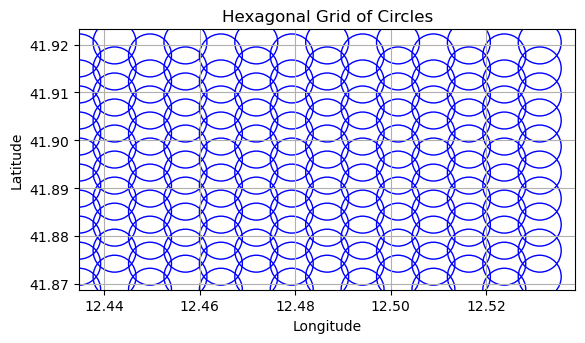

In [33]:
import math
import matplotlib.pyplot as plt

# Center point (latitude and longitude)
center_lat = latitude_dd  # Replace with your center latitude
center_lng = longitude_dd  # Replace with your center longitude

# Radius of the center circle in meters
radius_meters = 500  # 500 meters

# Calculate the horizontal and vertical spacing between circles in degrees
radius = (radius_meters / 1000) / 111.32 

# Number of rows and columns in the hexagonal grid
num_rows = 10
num_cols = 14

# Calculate the horizontal and vertical spacing between circles
h_spacing = 3/2 * radius * 1.1
v_spacing = math.sqrt(3) * radius * 0.7

# Calculate the coordinates of the top-left corner of the grid
x_min = center_lng - (num_cols - 1) * h_spacing / 2
y_min = center_lat - (num_rows - 1) * v_spacing / 2

# Create a figure and axis for plotting
fig, ax = plt.subplots()

locations = []
# Generate coordinates for the hexagonal grid of circles
for row in range(num_rows):
    for col in range(num_cols):
        # Calculate the coordinates for the center of each circle in the grid
        x = x_min + col * h_spacing
        y = y_min + row * v_spacing
        locations.append([x,y])
        # Offset every other row
        if col % 2 == 1:
            y += v_spacing / 2
        
        # Create a circle with the specified radius
        circle = plt.Circle((x, y), radius, fill=False, color='blue')
        
        # Add the circle to the plot
        ax.add_patch(circle)

# Set the aspect ratio to be equal (so circles look like circles)
ax.set_aspect('equal', adjustable='box')

# Calculate axis limits based on the grid's extent
x_max = x_min + num_cols * h_spacing 
y_max = y_min + num_rows * v_spacing

# Set the axis limits
ax.set_xlim(x_min , x_max)
ax.set_ylim(y_min , y_max)

# Show the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hexagonal Grid of Circles')
plt.grid(True)
plt.show()


In [35]:
len(locations)

140

In [34]:
with open('./output/loc.txt', 'w') as f:
    for loc in locations:
        f.write(f'{loc[0]},{loc[1]}\n')